In [2]:
# import warnings
# warnings.filterwarnings("ignore")

import csv
import numpy as np
import pandas as pd
# import geopandas as gpd
from IPython.display import Image
# from shapely.geometry import Point, Polygon
from math import factorial
import scipy
import scipy.signal
import os, os.path

from datetime import date
import datetime
import time

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import LinearRegression
from patsy import cr

# from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sb

import sys

from pylab import rcParams


# to move files from one directory to another
import shutil

In [3]:
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/remote_sensing/python/')
import remote_sensing_core as rc
import remote_sensing_plot_core as rcp

In [4]:
output_dir = "/Users/hn/Documents/01_research_data/remote_sensing/LandSat_NASA/data_for_combined_plots/"

# Extract Landsat data

In [5]:
data_dir = "/Users/hn/Documents/01_research_data/remote_sensing/LandSat_NASA/"

In [6]:
EVI_8day = pd.read_csv(data_dir + "NASA_LandSt_8dayEVI.csv", low_memory = False)
EVI_8day_IDS = list(EVI_8day.ID.unique())

In [7]:
EVI_8day = rc.add_human_start_time(EVI_8day)

EVI_8day["image_year"] = EVI_8day['human_system_start_time'].dt.year
EVI_8day['SF_year'] = 2017


In [8]:
EVI_8day = rc.fill_missing_doi_for_8DayEVI_Landsat_from_human_system_time(EVI_8day)

EVI_8day["EVI"].fillna(-1.5, inplace=True)

In [9]:
EVI_8day_noGap = pd.DataFrame()

for a_field in EVI_8day_IDS:
    curr_field = EVI_8day[EVI_8day.ID == a_field].copy()
    curr_field = rc.fill_theGap_linearLine(regular_TS = curr_field, V_idx="EVI", SF_year=2017)
    EVI_8day_noGap = pd.concat([EVI_8day_noGap, curr_field])

# Apply SG method

In [10]:
EVI_8day_noGap["SG_EVI"] = 0

# Savitky-Golay parameters:
window_len = 7
poly_order = 3

for a_field in EVI_8day_IDS:
    curr_field = EVI_8day_noGap[EVI_8day_noGap.ID == a_field].copy()
    curr_idx = EVI_8day_noGap[EVI_8day_noGap.ID == a_field].index.values
    
    y = curr_field.EVI.values
    SG_pred = scipy.signal.savgol_filter(y, window_length = window_len, polyorder = poly_order)
    
    EVI_8day_noGap.loc[curr_idx, "SG_EVI"] = SG_pred

#
# SG might violate the boundaries. clip them:
#
upper_viol_idx = EVI_8day_noGap[EVI_8day_noGap.SG_EVI > 1 ].index.values
EVI_8day_noGap.loc[upper_viol_idx, "SG_EVI"] = 1

lower_viol_idx = EVI_8day_noGap[EVI_8day_noGap.SG_EVI <- 1 ].index.values
EVI_8day_noGap.loc[lower_viol_idx, "SG_EVI"] = -1

# Make it fine

In [84]:
fine_landsat = pd.DataFrame()
SEOS_landsat = pd.DataFrame()

SFYr = 2017
onset_cut = 0.3
offset_cut = 0.3

In [85]:
for a_field in EVI_8day_IDS:
    twoYears_EVI8Day = EVI_8day_noGap[EVI_8day_noGap.ID == a_field].copy()

    crr_fld_twoYrs_regular = twoYears_EVI8Day.copy()
    if (not("human_system_start_time" in list(crr_fld_twoYrs_regular.columns))):
        crr_fld_twoYrs_regular = rc.add_human_start_time(crr_fld_twoYrs_regular)


    ID = crr_fld_twoYrs_regular['ID'].unique()[0]

    #############################################
    # crr_fld will be one year from now on
    crr_fld = crr_fld_twoYrs_regular.copy()
    crr_fld = crr_fld[crr_fld.image_year == SFYr]

    #############################################
    ###
    ###             fine granularity table
    ###
    #############################################
    # create the full calenadr to make better estimation of SOS and EOS.
    fine_granular_table = rc.create_calendar_table(SF_year = SFYr)
    fine_granular_table.rename(columns={"Date": "human_system_start_time"}, inplace=True)
    fine_granular_table = pd.merge(fine_granular_table, crr_fld, 
                                   on=['human_system_start_time', 'SF_year', 'doy'], how='left')

    ###### We need to fill the NAs that are created because they were not created in fine_granular_table
    fine_granular_table["image_year"] = crr_fld["image_year"].unique()[0]
    fine_granular_table["ID"]     = crr_fld["ID"].unique()[0]
    fine_granular_table["county"] = crr_fld["county"].unique()[0]
    fine_granular_table["CropTyp"] = crr_fld["CropTyp"].unique()[0]
    fine_granular_table["DataSrc"] = crr_fld["DataSrc"].unique()[0]

    fine_granular_table["Irrigtn"] = crr_fld["Irrigtn"].unique()[0]

    fine_granular_table["LstSrvD"] = crr_fld["LstSrvD"].unique()[0]
    fine_granular_table["Notes"]   = crr_fld["Notes"].unique()[0]
    fine_granular_table["RtCrpTy"] = crr_fld["RtCrpTy"].unique()[0]

    # replace NAs with -1.5. Because, that is what the function fill_theGap_linearLine()
    # uses as indicator for missing values
    fine_granular_table.fillna(value={"SG_EVI":-1.5}, inplace=True)

    fine_granular_table = rc.fill_theGap_linearLine(regular_TS = fine_granular_table, 
                                                    V_idx = "SG_EVI", 
                                                    SF_year=SFYr)

    #
    # update SG_pred so that we do not have to update too many other stuff.
    #
    SG_pred = fine_granular_table["SG_EVI"].values.copy()
    crr_fld = fine_granular_table

    fine_landsat = pd.concat([fine_landsat, fine_granular_table])


    crr_fld ["SG_EVI"] = SG_pred
    crr_fld = rc.addToDF_SOS_EOS_White(pd_TS = crr_fld, VegIdx = "SG_EVI", 
                                       onset_thresh = onset_cut, offset_thresh = offset_cut)

    ##
    ##  Kill bad detected seasons 
    ##
    crr_fld['Date'] = crr_fld.human_system_start_time
    crr_fld = rc.Null_SOS_EOS_by_DoYDiff(pd_TS = crr_fld, min_season_length=40)

    SOS_index = list(crr_fld[crr_fld.SOS !=0].index)
    EOS_index = list(crr_fld[crr_fld.EOS !=0].index)

    SEOS_table = crr_fld.loc[EOS_index + SOS_index,]
    SEOS_landsat = pd.concat([SEOS_landsat, SEOS_table])

In [86]:
fine_landsat.head(2)

,human_system_start_time,SF_year,doy,ID,county,DataSrc,CropTyp,EVI,Irrigtn,RtCrpTy,LstSrvD,Notes,system_start_time,image_year,SG_EVI
0,2017-01-01,2017,1,108447_WSDA_SF_2017,Grant,wsda,"corn, field",NaN,rill,Alfalfa Hay,2017/07/11,NaN,NaN,2017,0.067547
1,2017-01-02,2017,2,108447_WSDA_SF_2017,Grant,wsda,"corn, field",NaN,rill,Alfalfa Hay,2017/07/11,NaN,NaN,2017,0.067547


In [119]:
a_fine_field = fine_landsat[fine_landsat.ID == EVI_8day_IDS[2]]
a_raw_field = EVI_8day_noGap[EVI_8day_noGap.ID == EVI_8day_IDS[2]]

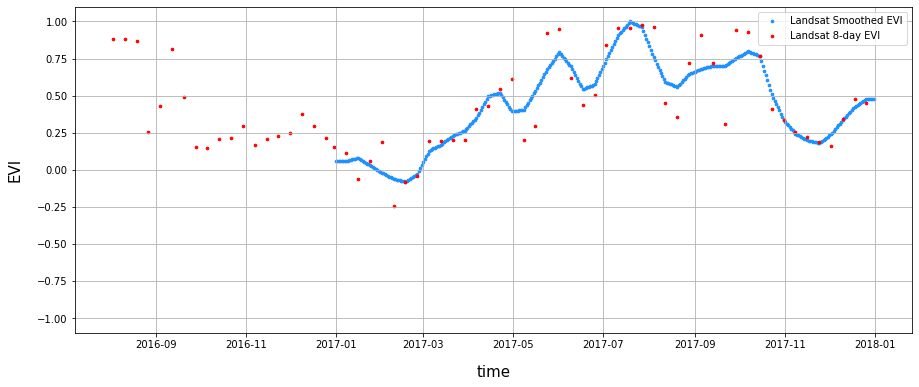

In [126]:
fig, ax = plt.subplots();
fig.set_size_inches(15, 6)

################################################
#
#   plot the data
#

x = a_fine_field.human_system_start_time.values
y = a_fine_field.SG_EVI.values
ax.scatter(x, y, c ='dodgerblue', s=7, label = 'Landsat Smoothed EVI')

x = a_raw_field.human_system_start_time.values
y = a_raw_field.EVI.values
ax.scatter(x, y, c='r', s=7, label="Landsat 8-day EVI")


################################################
#
# Set labels and ticks
#
ax.set_xlabel('time', fontsize = 15, labelpad = 15);
ax.set_ylabel('EVI', fontsize = 15, labelpad = 15);
ax.tick_params(axis = 'y', which = 'major', labelsize = 10)
ax.tick_params(axis = 'x', which = 'major', labelsize = 10)
ax.legend(loc="best", fontsize=10);
ax.set_ylim([-1.1, 1.1])

ax.grid(True);

plt.show();

# Save fine and SOS for Landsat

In [127]:
out_name = output_dir + "landsat_fine.csv"
fine_landsat.to_csv(out_name, index = False)

out_name = output_dir + "landsat_SEOS.csv"
SEOS_landsat.to_csv(out_name, index = False)

# Extract Raw Sentinel

In [128]:
# data_dir = "/Users/hn/Documents/01_research_data/remote_sensing/01_NDVI_TS/70_Cloud/00_Eastern_WA_withYear/2Years/"
# EasternWA = pd.read_csv(data_dir + "Eastern_WA_2017_70cloud_selectors.csv", low_memory = False) 
# EasternWA = EasternWA[EasternWA.county == "Grant"]

# three_fields = EasternWA[EasternWA.ID.isin(EVI_8day_IDS)]
# out_name = output_dir + "three_fields_sentinel_raw.csv"
# three_fields.to_csv(out_name, index = False)

In [183]:
sentinel_data_dir = output_dir
sentinel_raw = pd.read_csv(sentinel_data_dir + "three_fields_sentinel_raw.csv", low_memory = False) 

# Create Sentinel fine

In [142]:
regular_sentinel_dir = "/Users/hn/Documents/01_research_data/remote_sensing/data_for_plots_in_paper/"
all_df = pd.read_csv(regular_sentinel_dir + "01_Regular_filledGap_Grant_SF_2017_EVI.csv", low_memory=False)

In [166]:
three_reg_sentinel = all_df[all_df.ID.isin(EVI_8day_IDS)].copy()
three_reg_sentinel.reset_index(drop=True, inplace=True)

In [167]:
indeks = "EVI"
given_county= "Grant"
SF_year = 2017

In [168]:
if 'Date' in three_reg_sentinel.columns:
    if type(three_reg_sentinel.Date.iloc[0]) == str:
        three_reg_sentinel['Date'] = pd.to_datetime(three_reg_sentinel.Date.values).values

In [169]:
three_reg_sentinel['SF_year'] = SF_year

In [170]:
three_reg_sentinel = rc.initial_clean(df = three_reg_sentinel, column_to_be_cleaned = "EVI")

In [171]:
three_reg_sentinel.sort_values(by=['ID', 'image_year', 'doy'], inplace=True)

In [174]:
a_field_for = three_reg_sentinel[three_reg_sentinel.ID == EVI_8day_IDS[0]].copy()
a_field_for.shape

(51, 22)

### Make it fine

In [200]:
all_sentinel_fine = pd.DataFrame()
all_sentinel_SEOS = pd.DataFrame()

idx = "EVI"

In [201]:
for a_field_ID in EVI_8day_IDS:
    a_field_for = three_reg_sentinel[three_reg_sentinel.ID == a_field_ID].copy()
    crr_fld_twoYrs_regular = a_field_for.copy()

    if (not("human_system_start_time" in list(crr_fld_twoYrs_regular.columns))):
        crr_fld_twoYrs_regular = rc.add_human_start_time(crr_fld_twoYrs_regular)

    twoYrs_regular_Yvalues = crr_fld_twoYrs_regular[idx].copy()
    twoYrs_regular_Xvalues = crr_fld_twoYrs_regular['Date'].copy()

    #############################################
    ###
    ###             Smoothen
    ###
    #############################################
    # differences are minor, but lets keep using Pythons function
    window_len = 7
    poly_order = 3

    SG_pred_twoYears = scipy.signal.savgol_filter(twoYrs_regular_Yvalues, 
                                                  window_length= window_len, polyorder=poly_order)

    # SG might violate the boundaries. clip them:
    SG_pred_twoYears[SG_pred_twoYears > 1 ] = 1
    SG_pred_twoYears[SG_pred_twoYears < -1 ] = -1

    crr_fld_twoYrs_regular[idx] = SG_pred_twoYears

    # crr_fld will be one year from now on
    crr_fld = crr_fld_twoYrs_regular.copy()
    crr_fld = crr_fld[crr_fld.image_year == SFYr]
    #############################################
    ###
    ###             fine granularity table
    ###
    #############################################
    # create the full calenadr to make better estimation of SOS and EOS.
    fine_granular_table = rc.create_calendar_table(SF_year = SFYr)
    fine_granular_table = pd.merge(fine_granular_table, crr_fld, on=['Date', 'SF_year', 'doy'], how='left')

    ###### We need to fill the NAs that are created because they were not created in fine_granular_table
    fine_granular_table["image_year"] = crr_fld["image_year"].unique()[0]
    fine_granular_table["ID"]     = crr_fld["ID"].unique()[0]
    fine_granular_table["Acres"]  = crr_fld["Acres"].unique()[0]
    fine_granular_table["county"] = crr_fld["county"].unique()[0]

    fine_granular_table["CropGrp"] = crr_fld["CropGrp"].unique()[0]
    fine_granular_table["CropTyp"] = crr_fld["CropTyp"].unique()[0]
    fine_granular_table["DataSrc"] = crr_fld["DataSrc"].unique()[0]
    fine_granular_table["ExctAcr"] = crr_fld["ExctAcr"].unique()[0]

    fine_granular_table["IntlSrD"] = crr_fld["IntlSrD"].unique()[0]
    fine_granular_table["Irrigtn"] = crr_fld["Irrigtn"].unique()[0]

    fine_granular_table["LstSrvD"] = crr_fld["LstSrvD"].unique()[0]
    fine_granular_table["Notes"]   = crr_fld["Notes"].unique()[0]
    fine_granular_table["RtCrpTy"] = crr_fld["RtCrpTy"].unique()[0]
    fine_granular_table["Shap_Ar"] = crr_fld["Shap_Ar"].unique()[0]
    fine_granular_table["Shp_Lng"] = crr_fld["Shp_Lng"].unique()[0]
    fine_granular_table["TRS"] = crr_fld["TRS"].unique()[0]

    fine_granular_table = rc.add_human_start_time_by_YearDoY(fine_granular_table)

    # replace NAs with -1.5. Because, that is what the function fill_theGap_linearLine()
    # uses as indicator for missing values
    fine_granular_table.fillna(value={idx:-1.5}, inplace=True)

    fine_granular_table = rc.fill_theGap_linearLine(regular_TS = fine_granular_table, 
                                                    V_idx=idx, 
                                                    SF_year=SFYr)
    
    all_sentinel_fine = pd.concat([all_sentinel_fine, fine_granular_table])

    # update SG_pred so that we do not have to update too many other stuff.
    SG_pred = fine_granular_table[idx].values.copy()
    crr_fld = fine_granular_table
    y = fine_granular_table[idx].copy()

    ###
    ###   plot SOS and EOS
    ###
    # Update the EVI/NDVI values to the smoothed version.
    crr_fld [idx] = SG_pred
    crr_fld = rc.addToDF_SOS_EOS_White(pd_TS = crr_fld, 
                                       VegIdx = idx, 
                                       onset_thresh = onset_cut, 
                                       offset_thresh = offset_cut)

    ##
    ##  Kill bad detected seasons 
    ##
    crr_fld = rc.Null_SOS_EOS_by_DoYDiff(pd_TS = crr_fld, min_season_length=40)

    SOS_index = list(crr_fld[crr_fld.SOS !=0].index)
    EOS_index = list(crr_fld[crr_fld.EOS !=0].index)
    SEOS_table = crr_fld.loc[EOS_index + SOS_index,]
    
    all_sentinel_SEOS = pd.concat([all_sentinel_SEOS, SEOS_sentinel])


# Plot for visual inspection

In [206]:
a_fine_field = all_sentinel_fine[all_sentinel_fine.ID == EVI_8day_IDS[2]]

a_raw_sentinel = sentinel_raw[sentinel_raw.ID == EVI_8day_IDS[2]] 
a_raw_sentinel = rc.initial_clean(df = a_raw_sentinel, column_to_be_cleaned = "EVI")
a_raw_sentinel = rc.add_human_start_time(a_raw_sentinel)

a_SEOS_field = all_sentinel_SEOS[all_sentinel_SEOS.ID == EVI_8day_IDS[2]]
# a_raw_field = all_sentinel_SEOS[all_sentinel_SEOS.ID == EVI_8day_IDS[2]]

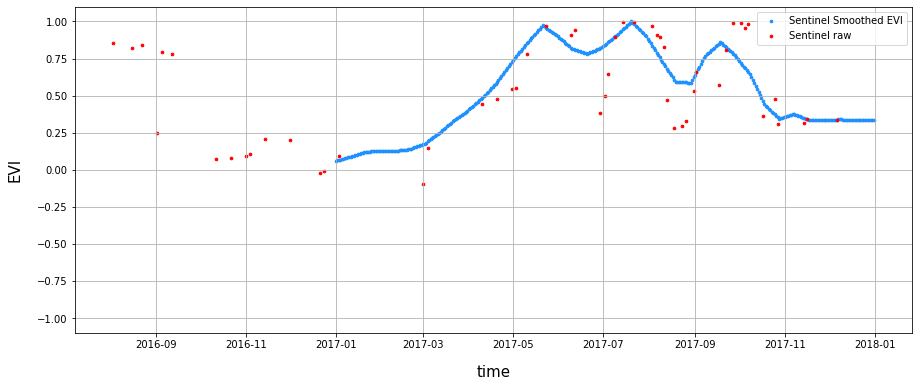

In [211]:
fig, ax = plt.subplots();
fig.set_size_inches(15, 6)

################################################
#
#   plot the data
#

x = a_fine_field.human_system_start_time.values
y = a_fine_field.EVI.values
ax.scatter(x, y, c ='dodgerblue', s=7, label = 'Sentinel Smoothed EVI')

x = a_raw_sentinel.human_system_start_time.values
y = a_raw_sentinel.EVI.values
ax.scatter(x, y, c='r', s=7, label="Sentinel raw")

################################################
#
# Set labels and ticks
#
ax.set_xlabel('time', fontsize = 15, labelpad = 15);
ax.set_ylabel('EVI', fontsize = 15, labelpad = 15);
ax.tick_params(axis = 'y', which = 'major', labelsize = 10)
ax.tick_params(axis = 'x', which = 'major', labelsize = 10)
ax.legend(loc="best", fontsize=10);
ax.set_ylim([-1.1, 1.1])

ax.grid(True);

plt.show();

# Save Sentinel Data

In [212]:
out_name = output_dir + "all_sentinel_fine.csv"
all_sentinel_fine.to_csv(out_name, index = False)

out_name = output_dir + "all_sentinel_SEOS.csv"
all_sentinel_SEOS.to_csv(out_name, index = False)

# Plot Sentinel and Landsat Simultaneously

In [287]:
plot_dir = "/Users/hn/Documents/01_research_data/remote_sensing/LandSat_NASA/"

In [288]:
size=15
title_FontSize = 15
legend_FontSize = 12
tick_FontSize = 18
label_FontSize = 22

params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 10}


#
#  Once set, you cannot change them, unless restart the notebook
#
plt.rc('font', family = 'georgia')
# plt.rc('xtick', labelsize = 15)
# plt.rc('ytick', labelsize = 15) # x-small

plt.rcParams.update(params)

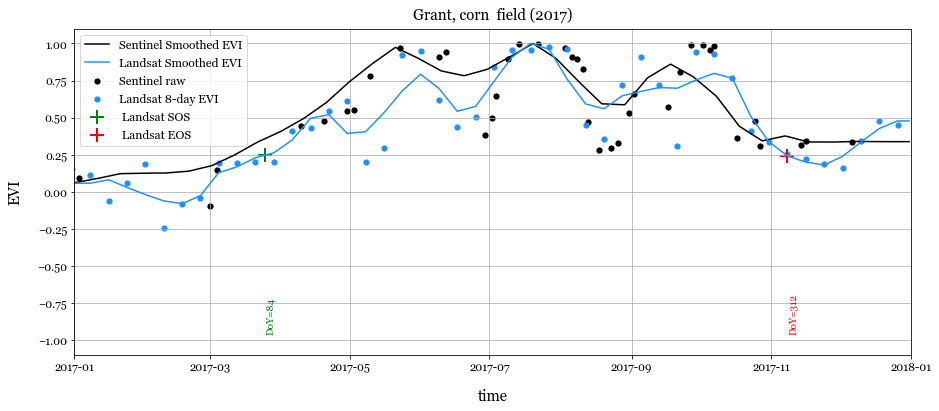

In [301]:
curr_ID = EVI_8day_IDS[2]

################################################
######
######   Subset Landsat data
######
curr_landsat_raw = EVI_8day_noGap[EVI_8day_noGap.ID == curr_ID]
curr_landsat_smooth = fine_landsat[fine_landsat.ID == curr_ID]

curr_landsat_SOS = SEOS_landsat[(SEOS_landsat.ID == curr_ID) & (SEOS_landsat.SOS != 0)]
curr_landsat_EOS = SEOS_landsat[(SEOS_landsat.ID == curr_ID) & (SEOS_landsat.EOS != 0)]

################################################
######
######   Subset Sentinel data
######
curr_sentinel_smooth = all_sentinel_fine[all_sentinel_fine.ID == curr_ID]

curr_sentinel_raw = sentinel_raw[sentinel_raw.ID == curr_ID].copy()
curr_sentinel_raw = rc.initial_clean(df = curr_sentinel_raw, column_to_be_cleaned = "EVI")
curr_sentinel_raw = rc.add_human_start_time(curr_sentinel_raw)

fig, ax = plt.subplots();
fig.set_size_inches(15, 6)

################################################
#
#   plot Sentinel data
#

# ax.scatter(curr_sentinel_smooth.human_system_start_time.values, 
#            curr_sentinel_smooth.EVI.values, 
#            c ='dodgerblue', s=7,
#            label = 'Sentinel Smoothed EVI')

ax.plot(curr_sentinel_smooth.human_system_start_time.values, 
        curr_sentinel_smooth.EVI.values, 
        c ='k',
        label = 'Sentinel Smoothed EVI')

ax.scatter(curr_sentinel_raw.human_system_start_time.values, 
           curr_sentinel_raw.EVI.values, 
           c='k', s = 27, label="Sentinel raw")

################################################
#
#   plot Landsat data
#

# ax.scatter(curr_landsat_smooth.human_system_start_time.values, 
#            curr_landsat_smooth.SG_EVI.values, 
#            c ='dodgerblue', s=7, label = 'Landsat Smoothed EVI')

ax.plot(curr_landsat_smooth.human_system_start_time.values, 
           curr_landsat_smooth.SG_EVI.values, 
           c ='dodgerblue', label = 'Landsat Smoothed EVI')

ax.scatter(curr_landsat_raw.human_system_start_time.values, 
           curr_landsat_raw.EVI.values, 
           c='dodgerblue', s = 27, label="Landsat 8-day EVI")

#
#  Plot SOS and EOS
#

ax.scatter(curr_landsat_SOS['human_system_start_time'], curr_landsat_SOS['SOS'], 
           marker='+', s = 200, linewidths = 2, 
           c = 'g', label = " Landsat SOS")

ax.scatter(curr_landsat_EOS['human_system_start_time'], curr_landsat_EOS['EOS'], 
           marker='+', s = 200, linewidths = 2, 
           c = 'r', label = " Landsat EOS")


#
# Anotate S/EOS
#

for ii in np.arange(0, len(curr_landsat_SOS)):
    style = dict(size=10, color='g', rotation='vertical')
    ax.text(x = curr_landsat_SOS.iloc[ii]['human_system_start_time'].date(), 
            y = -0.95, 
            s = 'DoY=' + str(curr_landsat_SOS.iloc[ii]['doy']), 
            **style)

for ii in np.arange(0, len(curr_landsat_EOS)):
    style = dict(size=10, color='r', rotation='vertical')
    ax.text(x = curr_landsat_EOS.iloc[ii]['human_system_start_time'].date(), 
            y = -0.95, 
            s = 'DoY=' + str(curr_landsat_EOS.iloc[ii]['doy']), 
            **style)

################################################
#
# Set labels and ticks
#
ax.set_xlabel('time', labelpad = 15);
ax.set_ylabel('EVI', labelpad = 15);
ax.tick_params(axis = 'y', which = 'major')
ax.tick_params(axis = 'x', which = 'major')

if curr_ID == "99423_WSDA_SF_2017":
    ax.legend(loc = "lower right");
else:
    ax.legend(loc = "best");

ax.set_ylim([-1.1, 1.1])
ax.set_xlim([datetime.date(2017, 1, 1), datetime.date(2018, 1, 1)])

ax.grid(True);

################################### Form Title
county = crr_fld_twoYrs_regular['county'].unique()[0]
plant = crr_fld_twoYrs_regular['CropTyp'].unique()[0]
plant = plant.replace(",", " ")


plot_title = county + ", " + plant + " (2017)" 
ax.set_title(plot_title);

file_name = plot_dir + curr_ID + "_Land_Sentinel.png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight', transparent=False)

plt.show();

In [300]:
curr_ID

'107433_WSDA_SF_2017'